# Idea
Generate 1000 attacks and use the following features to fit a detection head on them for decision making:
1. $MSE(x, f_{recon}(x|\hat{c}))$
2. $D(x)$ (veracity)
3. $p(\hat{c}|x)$ from $D_{aux}$
5. $p(\hat{c}|x)$ from the victim
6. $JS(victim(x), D_{aux}(x))$
4. $\log(D(x)) + \log(p(\hat{c}|x))$

# REMEMBER: Convert all outputs to probability distributions!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys  # TODO: Fix this?

sys.path.append("PyTorch-StudioGAN/")
import itertools
import random

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from Attacks.attacks_suite import *
from Classifiers.resnet import load_model as load_victim_model
from Defense.def_utils import *
import json
from functools import partial

import numpy as np

from gan_loader import load_model as load_gan_model
from LGDPM.diffusion_loader import load_model as load_diffusion_model
from sklearn.model_selection import GridSearchCV, train_test_split
from torchmetrics.functional.classification import binary_auroc, multiclass_accuracy
from torchmetrics.functional.regression import kl_divergence
from torchvision import datasets, transforms as T
from tqdm import tqdm
from xgboost import XGBClassifier

assert torch.cuda.is_available()


In [3]:
seed = 42
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True

random.seed(seed);
np.random.seed(seed);
torch.cuda.manual_seed(seed);
torch.manual_seed(seed);


In [4]:
class NormalizeInverse(T.Normalize):
    def __init__(self, mean, std, *args, **kwargs):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv, *args, **kwargs)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [5]:
def JSD(p, q, log_prob=False):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m, log_prob=log_prob) + 0.5 * kl_divergence(
        q, m, log_prob=log_prob
    )


In [6]:
V_WEIGHTS = {
    "MNIST": "saved_models/victims/mnist_resnet18.pth",
    "CIFAR10": "saved_models/victims/cifar10_resnet18.pth",
    "TIMGNET": "saved_models/victims/timgnet_resnet18.pth",
}
cifar10_victim = load_victim_model(V_WEIGHTS["CIFAR10"], num_classes=10, in_channels=3)
timgnet_victim = load_victim_model(V_WEIGHTS["TIMGNET"], num_classes=200, in_channels=3)
cifar10_victim.eval()
timgnet_victim.eval()
VICTIM_MODELS = {
    "CIFAR10": cifar10_victim,
    "TIMGNET": timgnet_victim,
}


In [7]:
D_WEIGHTS = {
    "CIFAR10_DIFF": "saved_models/defenders/diffusion/cifar10_diff.pth",
    "TIMGNET_DIFF": "saved_models/defenders/diffusion/timgnet_diff.pth",
    "CIFAR10_REACGAN": (
        "saved_models/defenders/acgan/cifar10/G_cifar10_reacgan.pth",
        "saved_models/defenders/acgan/cifar10/D_cifar10_reacgan.pth",
    ),
    "TIMGNET_REACGAN": (
        "saved_models/defenders/acgan/timgnet/G_timgnet_reacgan.pth",
        "saved_models/defenders/acgan/timgnet/D_timgnet_reacgan.pth",
    ),
}


In [8]:
def generate_sample_baskets(n_samples=200):
    all_datasets = {
        "CIFAR10": datasets.CIFAR10(
            root="PyTorch-StudioGAN/data/",
            transform=T.Compose(
                [
                    T.ToTensor(),
                    T.Normalize(
                        DEFAULT_MOMENTS.CIFAR10.mean, DEFAULT_MOMENTS.CIFAR10.std
                    ),
                ]
            ),
        ),
        "TIMGNET": datasets.ImageFolder(
            root="PyTorch-StudioGAN/data/tiny-imagenet-200/train/",
            transform=T.Compose(
                [
                    T.ToTensor(),
                    T.Normalize(
                        DEFAULT_MOMENTS.TIMGNET.mean, DEFAULT_MOMENTS.TIMGNET.std
                    ),
                ]
            ),
        ),
    }
    samples = {}
    for name, ds in all_datasets.items():
        targets = torch.tensor(ds.targets)
        all_classes = torch.unique(targets)
        assert (
            n_samples % len(all_classes) == 0
        ), f"Cannot sample equally with the provided n_samples={n_samples} and n_targets={len(all_classes)}"
        n_samples_per_class = n_samples // len(all_classes)
        balanced_sample_indices = []
        for cls in all_classes:
            only_cls = torch.where(targets == cls)[0].tolist()
            balanced_sample_indices.extend(
                random.sample(only_cls, n_samples_per_class)
            )
        samples.update({name: [ds[idx] for idx in balanced_sample_indices]})
    return samples


In [9]:
def generate_attacks(victim, ds_name, real_sample_baskets, targeted=False, **kwargs):
    images, labels = zip(*real_sample_baskets[ds_name])
    images, labels = torch.stack(images).to("cuda"), torch.tensor(list(labels)).to(
        "cuda", dtype=torch.long
    )
    if isinstance(targeted, bool):
        suite = partial(run_attack_suite, targets="auto" if targeted else None)
    elif isinstance(targeted, torch.Tensor):
        suite = partial(run_attack_suite, targets=targeted)
    attacks = suite(victim, ds_name, images, labels, **kwargs)
    torch.cuda.empty_cache()
    return attacks


In [10]:
if os.path.exists("1k_real_sample_baskets.pth"):
    real_sample_baskets = torch.load("1k_real_sample_baskets.pth")
else:
    real_sample_baskets = generate_sample_baskets(n_samples=1000)
    torch.save(real_sample_baskets, "1k_real_sample_baskets.pth")
if os.path.exists("1k_ADV_ATTACKS.pth"):
    ADV_ATTACKS = torch.load("1k_ADV_ATTACKS.pth")
else:
    ADV_ATTACKS = {
        "CIFAR10": generate_attacks(
            cifar10_victim, "CIFAR10", real_sample_baskets, targeted=True, splits=10
        ),
        "TIMGNET": generate_attacks(
            timgnet_victim, "TIMGNET", real_sample_baskets, targeted=True, splits=10
        ),
    }
    torch.save(ADV_ATTACKS, "1k_ADV_ATTACKS.pth")


In [11]:
# TODO: have attacks and clean images here
# -> Discriminator Outputs
# -> Victim outputs
# -> Targeted Reconstruction
# -> Make training data
# -> Fit XGB

In [12]:
DEFENDER_DEFAULT_CONFIGS = {
    "DIFF": {
        "CIFAR10": "CIFAR10_DIFF",
        "TIMGNET": "TIMGNET_DIFF",
        "aux_d_type_for_diff": "REACGAN",
    },
    "ACGAN":{
        "CIFAR10": "CIFAR10_REACGAN",
        "TIMGNET": "TIMGNET_REACGAN",
    }
}

In [13]:
BASE_PATH = "DHT_models/"

# DIFFUSION

In [14]:
@torch.inference_mode()
def diffusion_metrics(
    conditional_diffuser,
    auxiliary_discriminator,
    inputs,
    labels,
    splits=1,
    **targeted_purify_kwargs
):
    num_channels = inputs.shape[1]
    discriminator_normalizer = T.Normalize(
        mean=DISCRIMINATOR_MOMENTS[num_channels]["mean"],
        std=DISCRIMINATOR_MOMENTS[num_channels]["std"],
    )
    recon_loss = diffusion_purify_targeted(
        conditional_diffuser,
        inputs,
        labels,
        return_purified=False,
        splits=splits,
        **targeted_purify_kwargs
    )
    dis_inputs = discriminator_normalizer(inputs).detach()
    dis_inputs_chunks = torch.chunk(dis_inputs, splits)
    veracity, class_posteriors = [], []
    for dis_inputs_chunk in dis_inputs_chunks:
        d_result = auxiliary_discriminator.forward_emb(dis_inputs_chunk)
        veracity.append(F.sigmoid(d_result["adv_output"].detach()))
        class_posteriors.append(F.softmax(d_result["cls_output"].detach(), dim=1))
    return recon_loss, torch.cat(veracity), torch.cat(class_posteriors)


In [15]:
NUM_SPLITS = 10
for dataset_name in ["CIFAR10", "TIMGNET"]:
    for attack_method in ["CW", "FGSM"]:
        training_file_name = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_train.pth"
        )
        if not os.path.exists(training_file_name):
            victim = VICTIM_MODELS[dataset_name]
            defender = DEFENDER_DEFAULT_CONFIGS["DIFF"][dataset_name]
            aux_d_name = (
                dataset_name
                + "_"
                + DEFENDER_DEFAULT_CONFIGS["DIFF"]["aux_d_type_for_diff"]
            )
            _, defender_diff_ema = load_diffusion_model(D_WEIGHTS[defender], defender)
            _, defender_D, _ = load_gan_model(
                D_WEIGHTS[aux_d_name][0], D_WEIGHTS[aux_d_name][1], aux_d_name
            )
            defender_D.eval()
            defender_diff_ema.eval()
            clean_images, clean_true_labels = zip(*real_sample_baskets[dataset_name])
            clean_images, clean_true_labels = torch.stack(clean_images).to(
                "cuda"
            ), torch.tensor(list(clean_true_labels)).to("cuda")
            adv_denorm_images, adv_norm_images, adv_true_labels = (
                ADV_ATTACKS[dataset_name][attack_method][
                    "unnormalized_clipped_samples"
                ],
                ADV_ATTACKS[dataset_name][attack_method]["normalized_clipped_samples"],
                ADV_ATTACKS[dataset_name]["clean_labels"],
            )
            inverse_normalizer = NormalizeInverse(
                mean=DEFAULT_MOMENTS[dataset_name]["mean"],
                std=DEFAULT_MOMENTS[dataset_name]["std"],
            )
            ### CLEAN
            # clean images are normalized!
            clean_images_chunks = torch.chunk(clean_images, NUM_SPLITS)
            clean_victim_class_posteriors = F.softmax(
                torch.cat(
                    [victim(chunk).detach() for chunk in clean_images_chunks], dim=0
                ),
                dim=1,
            )
            clean_victim_labels = torch.argmax(clean_victim_class_posteriors, dim=1)
            clean_victim_max_class_posteriors = clean_victim_class_posteriors.gather(
                dim=1, index=clean_victim_labels[:, None]
            ).squeeze()
            (
                clean_recon_loss,
                clean_veracity,
                clean_dis_class_posteriors,
            ) = diffusion_metrics(
                defender_diff_ema,
                defender_D,
                inverse_normalizer(clean_images),
                clean_victim_labels,
                splits=NUM_SPLITS,
                disable_tqdm=False,
            )
            clean_dis_max_class_posteriors = clean_dis_class_posteriors.gather(
                dim=1, index=clean_victim_labels[:, None]
            ).squeeze()
            clean_jsd = torch.as_tensor(
                list(
                    map(
                        JSD,
                        clean_victim_class_posteriors.unsqueeze(-2),
                        clean_dis_class_posteriors.unsqueeze(-2),
                    )
                )
            )
            clean_sum_of_logs = torch.log(clean_veracity) + torch.log(
                clean_dis_max_class_posteriors
            )

            ### ADVERSARIAL
            adv_images_chunks = torch.chunk(adv_norm_images, NUM_SPLITS)
            adv_victim_class_posteriors = F.softmax(
                torch.cat(
                    [victim(chunk).detach() for chunk in adv_images_chunks],
                    dim=0,
                ),
                dim=1,
            )
            adv_victim_labels = torch.argmax(adv_victim_class_posteriors, dim=1)
            adv_victim_max_class_posteriors = adv_victim_class_posteriors.gather(
                dim=1, index=adv_victim_labels[:, None]
            ).squeeze()
            adv_recon_loss, adv_veracity, adv_dis_class_posteriors = diffusion_metrics(
                defender_diff_ema,
                defender_D,
                adv_denorm_images,
                adv_victim_labels,
                splits=NUM_SPLITS,
                disable_tqdm=False,
            )
            adv_dis_max_class_posteriors = adv_dis_class_posteriors.gather(
                dim=1, index=adv_victim_labels[:, None]
            ).squeeze()
            adv_jsd = torch.as_tensor(
                list(
                    map(
                        JSD,
                        adv_victim_class_posteriors.unsqueeze(-2),
                        adv_dis_class_posteriors.unsqueeze(-2),
                    )
                )
            )
            adv_sum_of_logs = torch.log(adv_veracity) + torch.log(
                adv_dis_max_class_posteriors
            )

            ### AGGREGATE
            clean_X_train = torch.vstack(
                [
                    clean_recon_loss.cpu(),
                    clean_veracity.cpu(),
                    clean_dis_max_class_posteriors.cpu(),
                    clean_victim_max_class_posteriors.cpu(),
                    clean_jsd.cpu(),
                    clean_sum_of_logs.cpu(),
                ]
            )
            adv_X_train = torch.vstack(
                [
                    adv_recon_loss.cpu(),
                    adv_veracity.cpu(),
                    adv_dis_max_class_posteriors.cpu(),
                    adv_victim_max_class_posteriors.cpu(),
                    adv_jsd.cpu(),
                    adv_sum_of_logs.cpu(),
                ]
            )
            X_train = torch.vstack([clean_X_train.T, adv_X_train.T]).numpy()
            y_train = torch.vstack(
                [
                    torch.zeros(clean_X_train.shape[1], 1),
                    torch.ones(adv_X_train.shape[1], 1),
                ]
            ).numpy()
            training_data = {
                "X": X_train,
                "y": y_train,
            }
            torch.save(training_data, training_file_name)
        else:
            training_data = torch.load(training_file_name)
            X_train, y_train = training_data["X"], training_data["y"]

        ### TRAIN
        clf_file_name = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_XGB.json"
        )
        gridsearch_hist_file_name = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_GridSearchCV.hist"
        )
        best_params_file_name = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_best_params.json"
        )
        base_xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="auc")
        gridsearch_clf = GridSearchCV(
            base_xgb_model,
            {
                "max_depth": [1, 2, 3, 4, 5],
                "n_estimators": [2, 5, 10, 50],
            },
            verbose=1,
        )
        gridsearch_clf.fit(X_train, y_train)
        print(
            f"Best CV score: {gridsearch_clf.best_score_} - Best params: {gridsearch_clf.best_params_}"
        )
        torch.save(gridsearch_clf.cv_results_, gridsearch_hist_file_name)
        with open(best_params_file_name, "w") as hist_fp:
            json.dump(gridsearch_clf.best_params_, hist_fp)
        best_xgb_clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            **gridsearch_clf.best_params_,
        )
        best_xgb_clf.fit(X_train, y_train)
        print(
            f"{dataset_name} - {attack_method} XGB clf Score: {best_xgb_clf.score(X_train, y_train)}"
        )
        best_xgb_clf.save_model(clf_file_name)
        print(best_xgb_clf.feature_importances_)
        torch.cuda.empty_cache()


10it [02:34, 15.46s/it]
10it [02:24, 14.41s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9970000000000001 - Best params: {'max_depth': 1, 'n_estimators': 50}
CIFAR10 - CW XGB clf Score: 0.9995
[0.00583138 0.00497438 0.8556871  0.09806246 0.00697095 0.02847368]


10it [02:22, 14.27s/it]
10it [02:22, 14.28s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9345000000000001 - Best params: {'max_depth': 1, 'n_estimators': 50}
CIFAR10 - FGSM XGB clf Score: 0.9445
[0.01572933 0.01057607 0.11516175 0.7250773  0.01718033 0.11627524]


10it [02:22, 14.26s/it]
10it [02:22, 14.27s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9935 - Best params: {'max_depth': 1, 'n_estimators': 50}
CIFAR10 - PGD XGB clf Score: 0.998
[0.         0.0088792  0.5938653  0.09941047 0.02393176 0.2739133 ]


10it [14:12, 85.28s/it]
10it [14:22, 86.21s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9515 - Best params: {'max_depth': 3, 'n_estimators': 50}
TIMGNET - CW XGB clf Score: 0.973
[0.02677916 0.02733272 0.5959568  0.2210356  0.08465185 0.04424397]


10it [15:15, 91.54s/it]
10it [14:49, 88.92s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9844999999999999 - Best params: {'max_depth': 1, 'n_estimators': 50}
TIMGNET - FGSM XGB clf Score: 0.9875
[0.00554014 0.00526516 0.10966279 0.68457156 0.1291508  0.06580959]


10it [14:33, 87.39s/it]
10it [14:27, 86.73s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9630000000000001 - Best params: {'max_depth': 2, 'n_estimators': 50}
TIMGNET - PGD XGB clf Score: 0.9755
[0.0131713  0.01470757 0.14458884 0.13044733 0.617773   0.07931195]


## Ablation 1. Choice of Classifier

Dataset: CIFAR10, Attack: CW
Best Classifier: AdaBoost, Best Accuracy: 99.675 +/- 0.2385
	Classifier: kNN, Mean: 98.9125 +/- 0.4491
	Classifier: Linear SVM, Mean: 98.0875 +/- 0.5549
	Classifier: RBF SVM, Mean: 99.1125 +/- 0.3577
	Classifier: Gaussian Process, Mean: 99.1 +/- 0.3824
	Classifier: XGBoost, Mean: 99.65 +/- 0.3905
	Classifier: AdaBoost, Mean: 99.675 +/- 0.2385
	Classifier: Decision Tree, Mean: 99.4375 +/- 0.3863
	Classifier: Random Forest, Mean: 99.4 +/- 0.4569
	Classifier: Neural Net, Mean: 98.625 +/- 0.471
	Classifier: Naive Bayes, Mean: 99.0625 +/- 0.4248
	Classifier: QDA, Mean: 99.025 +/- 0.3437
Dataset: CIFAR10, Attack: FGSM
Best Classifier: XGBoost, Best Accuracy: 93.5625 +/- 1.272
	Classifier: kNN, Mean: 86.4375 +/- 1.7498
	Classifier: Linear SVM, Mean: 80.775 +/- 1.3984
	Classifier: RBF SVM, Mean: 87.8625 +/- 1.5562
	Classifier: Gaussian Process, Mean: 93.5 +/- 1.0665
	Classifier: XGBoost, Mean: 93.5625 +/- 1.272
	Classifier: AdaBoost, Mean: 93.4 +/- 1.1948
	Classifi

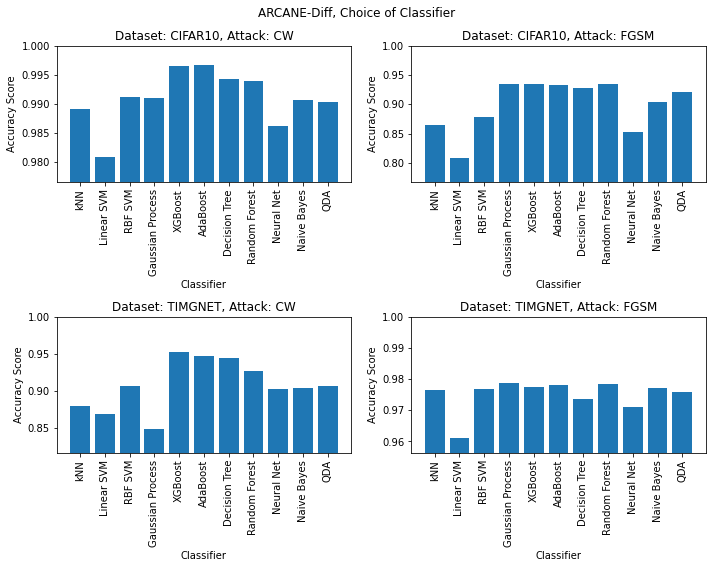

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

NUM_RUNS = 20

names = [
    "kNN",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "XGBoost",
    "AdaBoost",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "Naive Bayes",
    "QDA",
]
BASE_PATH = "DHT_models"
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, dataset_name in enumerate(["CIFAR10", "TIMGNET"]):
    for j, attack_method in enumerate(["CW", "FGSM"]):
        training_file_name = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_train.pth"
        )
        training_data = torch.load(training_file_name)
        X, y = training_data["X"], training_data["y"]
        accuracy_across_runs = []
        for _ in range(NUM_RUNS):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            y_train = y_train.ravel()
            y_test = y_test.ravel()
            accuracy_scores = []
            classifiers = [
                KNeighborsClassifier(3),
                SVC(kernel="linear", C=0.025),
                SVC(gamma=2, C=1, random_state=42),
                GaussianProcessClassifier(1.0 * RBF(1.0)),
                XGBClassifier(max_depth=3, n_estimators=50),
                AdaBoostClassifier(algorithm="SAMME", n_estimators=50),
                DecisionTreeClassifier(max_depth=5),
                RandomForestClassifier(
                    max_depth=3,
                    n_estimators=10,
                ),
                MLPClassifier(alpha=1, max_iter=1000),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),
            ]
            for name, clf in zip(names, classifiers):
                clf.fit(X_train, y_train)
                accuracy_scores.append(clf.score(X_test, y_test))
            accuracy_across_runs.append(accuracy_scores)
        accuracy_across_runs = np.asarray(accuracy_across_runs)
        mean_accuracy = accuracy_across_runs.mean(axis=0)
        std_accuracy = accuracy_across_runs.std(axis=0)
        best_clf_idx = np.argmax(mean_accuracy)

        print(
            f"Dataset: {dataset_name}, Attack: {attack_method}\n"
            f"Best Classifier: {names[best_clf_idx]}, Best Accuracy: {round(100*mean_accuracy[best_clf_idx], 4)} +/- {round(100*std_accuracy[best_clf_idx], 4)}"
        )
        for name, mean, std in zip(names, mean_accuracy, std_accuracy):
            print(
                f"\tClassifier: {name}, Mean: {round(100*mean ,4)} +/- {round(100*std, 4)}"
            )
        print("========================================================")
        axs[i, j].bar(names, mean_accuracy)
        axs[i, j].set_xlabel("Classifier")
        axs[i, j].set_ylabel("Accuracy Score")
        axs[i, j].set_ylim((np.min(mean_accuracy) - np.std(mean_accuracy), 1.0))
        axs[i, j].set_title(f"Dataset: {dataset_name}, Attack: {attack_method}")
        axs[i, j].set_xticklabels(names, rotation=90)
fig.suptitle("ARCANE-Diff, Choice of Classifier")
plt.tight_layout()
plt.show()


## Ablation 2. Choice of Features

In [2]:
features_in_order = [
    "Reconstruction Loss",
    "D(x)",
    "p_Aux(c_hat|x)",
    "p_Victim(c_hat|x)",
    "JSD",
    "Sum of Logs",
]
ablations = [3, 4, 5, 6]
delta_groups = {
    "global": {
        "34": [],
        "45": [],
        "56": [],
    },
    "by_dataset": {
        "CIFAR10": {
            "34": [],
            "45": [],
            "56": [],
        },
        "TIMGNET": {
            "34": [],
            "45": [],
            "56": [],
        },
    },
    "by_attack": {
        "CW": {
            "34": [],
            "45": [],
            "56": [],
        },
        "FGSM": {
            "34": [],
            "45": [],
            "56": [],
        },
    },
}
accs = {
    "global": {
        "3": [],
        "4": [],
        "5": [],
        "6": [],
    },
    "by_dataset": {
        "CIFAR10": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
        "TIMGNET": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
    },
    "by_attack": {
        "CW": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
        "FGSM": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
    },
}
BASE_PATH = "DHT_models"
for dataset_name in ["CIFAR10", "TIMGNET"]:
    for attack_method in ["CW", "FGSM"]:
        training_file_name = os.path.join(
            BASE_PATH, "DIFF", f"DIFF_{dataset_name}_{attack_method}_train.pth"
        )
        training_data = torch.load(training_file_name)
        X, y = training_data["X"], training_data["y"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        previous_score = None
        print(
            "==========================================================\n"
            f"Dataset Name: {dataset_name}, Attack: {attack_method}\n"
            "==========================================================\n"
        )
        for ablation in ablations:
            X_train_ablated = X_train[:, :ablation]
            y_train_ablated = y_train
            X_test_ablated = X_test[:, :ablation]
            y_test_ablated = y_test
            clf = XGBClassifier(max_depth=3, n_estimators=50)
            clf.fit(X_train_ablated, y_train_ablated)
            current_score = clf.score(X_test_ablated, y_test_ablated)
            delta = 0 if previous_score is None else current_score - previous_score
            match ablation:
                case 3:
                    accs["global"]["3"].append(current_score)
                    accs["by_attack"][attack_method]["3"].append(current_score)
                    accs["by_dataset"][dataset_name]["3"].append(current_score)
                case 4:
                    delta_groups["global"]["34"].append(delta)
                    delta_groups["by_attack"][attack_method]["34"].append(delta)
                    delta_groups["by_dataset"][dataset_name]["34"].append(delta)
                    accs["global"]["4"].append(current_score)
                    accs["by_attack"][attack_method]["4"].append(current_score)
                    accs["by_dataset"][dataset_name]["4"].append(current_score)
                case 5:
                    delta_groups["global"]["45"].append(delta)
                    delta_groups["by_attack"][attack_method]["45"].append(delta)
                    delta_groups["by_dataset"][dataset_name]["45"].append(delta)
                    accs["global"]["5"].append(current_score)
                    accs["by_attack"][attack_method]["5"].append(current_score)
                    accs["by_dataset"][dataset_name]["5"].append(current_score)
                case 6:
                    delta_groups["global"]["56"].append(delta)
                    delta_groups["by_attack"][attack_method]["56"].append(delta)
                    delta_groups["by_dataset"][dataset_name]["56"].append(delta)
                    accs["global"]["6"].append(current_score)
                    accs["by_attack"][attack_method]["6"].append(current_score)
                    accs["by_dataset"][dataset_name]["6"].append(current_score)

            previous_score = current_score
            print(
                f"\tAblation: {ablation}\n"
                f"\tFeatures Used: {', '.join(features_in_order[:ablation])}\n"
                f"\tCurrent Accuracy: {round(100*current_score, 4)}, Delta: {round(100*delta, 4)}\n"
                "========================"
            )

print(  # I'm sorry to whoever reads this. I was in a hurry.
    "AVERAGES:\n"
    "=========================\n"
    "\tGlobal Averages:\n"
    f"\t\t3: {round(100*np.mean(accs['global']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['global']['34']), 4)}, 4: {round(100*np.mean(accs['global']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['global']['45']), 4)}, 5: {round(100*np.mean(accs['global']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['global']['56']), 4)}, 6: {round(100*np.mean(accs['global']['6']), 4)}\n"
    "=========================\n"
    "\tAverages by Attack Method:\n"
    "\t\tCW:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_attack']['CW']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_attack']['CW']['34']), 4)}, 4: {round(100*np.mean(accs['by_attack']['CW']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_attack']['CW']['45']), 4)}, 5: {round(100*np.mean(accs['by_attack']['CW']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_attack']['CW']['56']), 4)}, 6: {round(100*np.mean(accs['by_attack']['CW']['6']), 4)}\n"
    "\t\tFGSM:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_attack']['FGSM']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_attack']['FGSM']['34']), 4)}, 4: {round(100*np.mean(accs['by_attack']['FGSM']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_attack']['FGSM']['45']), 4)}, 5: {round(100*np.mean(accs['by_attack']['FGSM']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_attack']['FGSM']['56']), 4)}, 6: {round(100*np.mean(accs['by_attack']['FGSM']['6']), 4)}\n"
    "=========================\n"
    "\tAverages by Dataset:\n"
    "\t\tCIFAR10:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_dataset']['CIFAR10']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_dataset']['CIFAR10']['34']), 4)}, 4: {round(100*np.mean(accs['by_dataset']['CIFAR10']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_dataset']['CIFAR10']['45']), 4)}, 5: {round(100*np.mean(accs['by_dataset']['CIFAR10']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_dataset']['CIFAR10']['56']), 4)}, 6: {round(100*np.mean(accs['by_dataset']['CIFAR10']['6']), 4)}\n"
    "\t\tTIMGNET:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_dataset']['TIMGNET']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_dataset']['TIMGNET']['34']), 4)}, 4: {round(100*np.mean(accs['by_dataset']['TIMGNET']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_dataset']['TIMGNET']['45']), 4)}, 5: {round(100*np.mean(accs['by_dataset']['TIMGNET']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_dataset']['TIMGNET']['56']), 4)}, 6: {round(100*np.mean(accs['by_dataset']['TIMGNET']['6']), 4)}\n"
    "=========================\n"
)


Dataset Name: CIFAR10, Attack: CW

	Ablation: 3
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x)
	Current Accuracy: 97.75, Delta: 0
	Ablation: 4
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x)
	Current Accuracy: 99.75, Delta: 2.0
	Ablation: 5
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x), JSD
	Current Accuracy: 99.75, Delta: 0.0
	Ablation: 6
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x), JSD, Sum of Logs
	Current Accuracy: 99.75, Delta: 0.0
Dataset Name: CIFAR10, Attack: FGSM

	Ablation: 3
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x)
	Current Accuracy: 84.5, Delta: 0
	Ablation: 4
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x)
	Current Accuracy: 96.5, Delta: 12.0
	Ablation: 5
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x), JSD
	Current Accuracy: 96.0, Delta: -0.5
	Ablation: 6
	Features Used: Reconstruction Loss, D(x)

# ACGAN

In [16]:
def acgan_metrics(
    conditional_generator,
    auxiliary_discriminator,
    inputs,
    labels,
    z_dim,
    splits=1,
    **targeted_purify_kwargs
):
    num_channels = inputs.shape[1]
    discriminator_normalizer = T.Normalize(
        mean=DISCRIMINATOR_MOMENTS[num_channels]["mean"],
        std=DISCRIMINATOR_MOMENTS[num_channels]["std"],
    )
    recon_loss = acgan_purify_targeted(
        conditional_generator,
        inputs,
        labels,
        z_dim,
        return_purified=False,
        splits=splits,
        **targeted_purify_kwargs
    )
    dis_inputs = discriminator_normalizer(inputs).detach()
    dis_inputs_chunks = torch.chunk(dis_inputs, splits)
    veracity, class_posteriors = [], []
    for dis_inputs_chunk in dis_inputs_chunks:
        d_result = auxiliary_discriminator.forward_emb(dis_inputs_chunk)
        veracity.append(F.sigmoid(d_result["adv_output"].detach()))
        class_posteriors.append(F.softmax(d_result["cls_output"].detach(), dim=1))
    return recon_loss, torch.cat(veracity), torch.cat(class_posteriors)

In [17]:
NUM_SPLITS = 10
for dataset_name in ["CIFAR10", "TIMGNET"]:
    for attack_method in ["CW", "FGSM"]:
        training_file_name = os.path.join(
            BASE_PATH, "ACGAN", f"ACGAN_{dataset_name}_{attack_method}_train.pth"
        )
        if not os.path.exists(training_file_name):
            victim = VICTIM_MODELS[dataset_name]
            defender = DEFENDER_DEFAULT_CONFIGS["ACGAN"][dataset_name]
            defender_G, defender_D, z_dim = load_gan_model(
                D_WEIGHTS[defender][0], D_WEIGHTS[defender][1], defender
            )
            defender_G.eval()
            defender_D.eval()
            clean_images, clean_true_labels = zip(*real_sample_baskets[dataset_name])
            clean_images, clean_true_labels = torch.stack(clean_images).to(
                "cuda"
            ), torch.tensor(list(clean_true_labels)).to("cuda")
            adv_denorm_images, adv_norm_images, adv_true_labels = (
                ADV_ATTACKS[dataset_name][attack_method][
                    "unnormalized_clipped_samples"
                ],
                ADV_ATTACKS[dataset_name][attack_method]["normalized_clipped_samples"],
                ADV_ATTACKS[dataset_name]["clean_labels"],
            )
            inverse_normalizer = NormalizeInverse(
                mean=DEFAULT_MOMENTS[dataset_name]["mean"],
                std=DEFAULT_MOMENTS[dataset_name]["std"],
            )
            ### CLEAN
            clean_images_chunks = torch.chunk(clean_images, NUM_SPLITS)
            clean_victim_class_posteriors = F.softmax(
                torch.cat(
                    [victim(chunk).detach() for chunk in clean_images_chunks], dim=0
                ),
                dim=1,
            )
            clean_victim_labels = torch.argmax(clean_victim_class_posteriors, dim=1)
            clean_victim_max_class_posteriors = clean_victim_class_posteriors.gather(
                dim=1, index=clean_victim_labels[:, None]
            ).squeeze()
            (
                clean_recon_loss,
                clean_veracity,
                clean_dis_class_posteriors,
            ) = acgan_metrics(
                defender_G,
                defender_D,
                inverse_normalizer(clean_images),
                clean_victim_labels,
                z_dim,
                splits=NUM_SPLITS,
                disable_tqdm=False,
            )
            clean_dis_max_class_posteriors = clean_dis_class_posteriors.gather(
                dim=1, index=clean_victim_labels[:, None]
            ).squeeze()
            clean_jsd = torch.as_tensor(
                list(
                    map(
                        JSD,
                        clean_victim_class_posteriors.unsqueeze(-2),
                        clean_dis_class_posteriors.unsqueeze(-2),
                    )
                )
            )
            clean_sum_of_logs = torch.log(clean_veracity) + torch.log(
                clean_dis_max_class_posteriors
            )

            ### ADVERSARIAL
            adv_images_chunks = torch.chunk(adv_norm_images, NUM_SPLITS)
            adv_victim_class_posteriors = F.softmax(
                torch.cat(
                    [victim(chunk).detach() for chunk in adv_images_chunks],
                    dim=0,
                ),
                dim=1,
            )
            adv_victim_labels = torch.argmax(adv_victim_class_posteriors, dim=1)
            adv_victim_max_class_posteriors = adv_victim_class_posteriors.gather(
                dim=1, index=adv_victim_labels[:, None]
            ).squeeze()
            adv_recon_loss, adv_veracity, adv_dis_class_posteriors = acgan_metrics(
                defender_G,
                defender_D,
                adv_denorm_images,
                adv_victim_labels,
                z_dim,
                splits=NUM_SPLITS,
                disable_tqdm=False,
            )
            adv_dis_max_class_posteriors = adv_dis_class_posteriors.gather(
                dim=1, index=adv_victim_labels[:, None]
            ).squeeze()
            adv_jsd = torch.as_tensor(
                list(
                    map(
                        JSD,
                        adv_victim_class_posteriors.unsqueeze(-2),
                        adv_dis_class_posteriors.unsqueeze(-2),
                    )
                )
            )
            adv_sum_of_logs = torch.log(adv_veracity) + torch.log(
                adv_dis_max_class_posteriors
            )

            ### AGGREGATE
            clean_X_train = torch.vstack(
                [
                    clean_recon_loss.detach().cpu(),
                    clean_veracity.detach().cpu(),
                    clean_dis_max_class_posteriors.detach().cpu(),
                    clean_victim_max_class_posteriors.detach().cpu(),
                    clean_jsd.detach().cpu(),
                    clean_sum_of_logs.detach().cpu(),
                ]
            )
            adv_X_train = torch.vstack(
                [
                    adv_recon_loss.detach().cpu(),
                    adv_veracity.detach().cpu(),
                    adv_dis_max_class_posteriors.detach().cpu(),
                    adv_victim_max_class_posteriors.detach().cpu(),
                    adv_jsd.detach().cpu(),
                    adv_sum_of_logs.detach().cpu(),
                ]
            )
            X_train = torch.vstack([clean_X_train.T, adv_X_train.T]).numpy()
            y_train = torch.vstack(
                [
                    torch.zeros(clean_X_train.shape[1], 1),
                    torch.ones(adv_X_train.shape[1], 1),
                ]
            ).numpy()
            training_data = {
                "X": X_train,
                "y": y_train,
            }
            torch.save(training_data, training_file_name)
        else:
            training_data = torch.load(training_file_name)
            X_train, y_train = training_data["X"], training_data["y"]

        ### TRAIN
        clf_file_name = os.path.join(
            BASE_PATH, "ACGAN", f"ACGAN_{dataset_name}_{attack_method}_XGB.json"
        )
        gridsearch_hist_file_name = os.path.join(
            BASE_PATH,
            "ACGAN",
            f"ACGAN_{dataset_name}_{attack_method}_GridSearchCV.hist",
        )
        best_params_file_name = os.path.join(
            BASE_PATH, "ACGAN", f"ACGAN_{dataset_name}_{attack_method}_best_params.json"
        )
        base_xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="auc")
        gridsearch_clf = GridSearchCV(
            base_xgb_model,
            {
                "max_depth": [1, 2, 3, 4, 5],
                "n_estimators": [2, 5, 10, 50],
            },
            verbose=1,
        )
        gridsearch_clf.fit(X_train, y_train)
        print(
            f"Best CV score: {gridsearch_clf.best_score_} - Best params: {gridsearch_clf.best_params_}"
        )
        torch.save(gridsearch_clf.cv_results_, gridsearch_hist_file_name)
        with open(best_params_file_name, "w") as hist_fp:
            json.dump(gridsearch_clf.best_params_, hist_fp)
        best_xgb_clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            **gridsearch_clf.best_params_,
        )
        best_xgb_clf.fit(X_train, y_train)
        print(
            f"{dataset_name} - {attack_method} XGB clf Score: {best_xgb_clf.score(X_train, y_train)}"
        )
        best_xgb_clf.save_model(clf_file_name)
        print(best_xgb_clf.feature_importances_)
        torch.cuda.empty_cache()


ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [00:44<00:00, 11.31it/s]
10it [07:21, 44.19s/it]
ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [00:44<00:00, 11.33it/s]
10it [07:22, 44.21s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9970000000000001 - Best params: {'max_depth': 1, 'n_estimators': 50}
CIFAR10 - CW XGB clf Score: 0.9995
[0.         0.00584522 0.86298263 0.09538148 0.00707443 0.02871611]


ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [00:44<00:00, 11.28it/s]
10it [07:23, 44.31s/it]
ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [00:44<00:00, 11.28it/s]
10it [07:23, 44.35s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9404999999999999 - Best params: {'max_depth': 1, 'n_estimators': 50}
CIFAR10 - FGSM XGB clf Score: 0.948
[0.01429752 0.01099937 0.12091529 0.71401864 0.0177051  0.12206416]


ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [00:44<00:00, 11.27it/s]
10it [07:23, 44.32s/it]
ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [00:44<00:00, 11.33it/s]
10it [07:22, 44.23s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9935 - Best params: {'max_depth': 1, 'n_estimators': 50}
CIFAR10 - PGD XGB clf Score: 0.998
[0.         0.0088792  0.5938653  0.09941047 0.02393176 0.2739133 ]


ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [01:09<00:00,  7.23it/s]
10it [10:59, 65.93s/it]
ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [01:04<00:00,  7.72it/s]
10it [10:47, 64.78s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.9515 - Best params: {'max_depth': 3, 'n_estimators': 50}
TIMGNET - CW XGB clf Score: 0.9725
[0.01939472 0.02565976 0.61750895 0.22071359 0.0800981  0.03662479]


ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [01:05<00:00,  7.61it/s]
10it [10:50, 65.10s/it]
ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [01:05<00:00,  7.61it/s]
10it [10:56, 65.68s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.984 - Best params: {'max_depth': 1, 'n_estimators': 50}
TIMGNET - FGSM XGB clf Score: 0.987
[0.00441428 0.00552707 0.11697416 0.6908551  0.12165723 0.06057219]


ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [01:05<00:00,  7.64it/s]
10it [10:54, 65.49s/it]
ACGAN Purify Targeted: Optimizing Z: 100%|██████████| 500/500 [01:05<00:00,  7.64it/s]
10it [10:54, 65.48s/it]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV score: 0.959 - Best params: {'max_depth': 3, 'n_estimators': 50}
TIMGNET - PGD XGB clf Score: 0.9875
[0.01349808 0.01824572 0.12875135 0.07903984 0.6781514  0.08231358]


## Ablation 1: Choice of Classifier

Dataset: CIFAR10, Attack: CW
Best Classifier: XGBoost, Best Accuracy: 99.725 +/- 0.2487
	Classifier: kNN, Mean: 98.5125 +/- 0.4435
	Classifier: Linear SVM, Mean: 98.0 +/- 0.6423
	Classifier: RBF SVM, Mean: 98.9375 +/- 0.5639
	Classifier: Gaussian Process, Mean: 98.9 +/- 0.443
	Classifier: XGBoost, Mean: 99.725 +/- 0.2487
	Classifier: AdaBoost, Mean: 99.5875 +/- 0.309
	Classifier: Decision Tree, Mean: 99.4375 +/- 0.4021
	Classifier: Random Forest, Mean: 99.4 +/- 0.4359
	Classifier: Neural Net, Mean: 98.6375 +/- 0.5835
	Classifier: Naive Bayes, Mean: 98.8875 +/- 0.503
	Classifier: QDA, Mean: 98.7875 +/- 0.4891
Dataset: CIFAR10, Attack: FGSM
Best Classifier: AdaBoost, Best Accuracy: 93.6 +/- 0.9434
	Classifier: kNN, Mean: 90.0625 +/- 1.0544
	Classifier: Linear SVM, Mean: 81.825 +/- 1.5127
	Classifier: RBF SVM, Mean: 88.0875 +/- 1.1626
	Classifier: Gaussian Process, Mean: 93.075 +/- 1.1014
	Classifier: XGBoost, Mean: 93.225 +/- 0.8976
	Classifier: AdaBoost, Mean: 93.6 +/- 0.9434
	Classifie

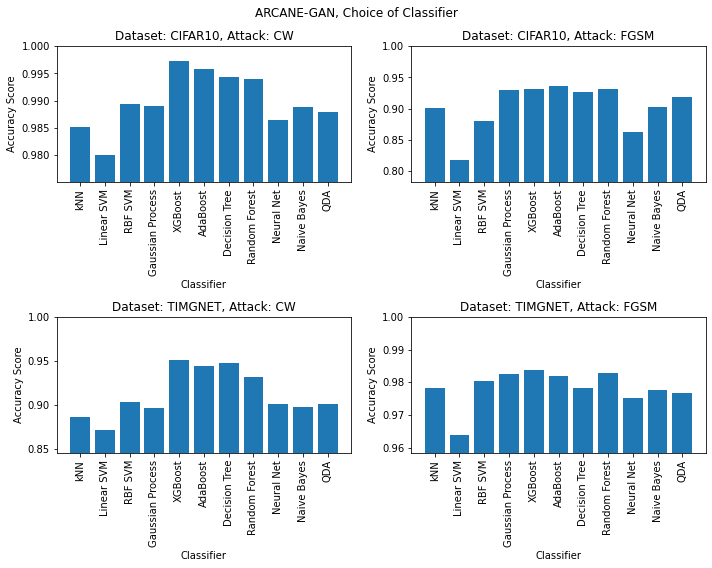

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

NUM_RUNS = 20

names = [
    "kNN",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "XGBoost",
    "AdaBoost",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "Naive Bayes",
    "QDA",
]
BASE_PATH = "DHT_models"
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, dataset_name in enumerate(["CIFAR10", "TIMGNET"]):
    for j, attack_method in enumerate(["CW", "FGSM"]):
        training_file_name = os.path.join(
            BASE_PATH, "ACGAN", f"ACGAN_{dataset_name}_{attack_method}_train.pth"
        )
        training_data = torch.load(training_file_name)
        X, y = training_data["X"], training_data["y"]
        accuracy_across_runs = []
        for _ in range(NUM_RUNS):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            y_train = y_train.ravel()
            y_test = y_test.ravel()
            accuracy_scores = []
            classifiers = [
                KNeighborsClassifier(3),
                SVC(kernel="linear", C=0.025),
                SVC(gamma=2, C=1, random_state=42),
                GaussianProcessClassifier(1.0 * RBF(1.0)),
                XGBClassifier(max_depth=3, n_estimators=50),
                AdaBoostClassifier(algorithm="SAMME", n_estimators=50),
                DecisionTreeClassifier(max_depth=5),
                RandomForestClassifier(
                    max_depth=3,
                    n_estimators=10,
                ),
                MLPClassifier(alpha=1, max_iter=1000),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),
            ]
            for name, clf in zip(names, classifiers):
                clf.fit(X_train, y_train)
                accuracy_scores.append(clf.score(X_test, y_test))
            accuracy_across_runs.append(accuracy_scores)
        accuracy_across_runs = np.asarray(accuracy_across_runs)
        mean_accuracy = accuracy_across_runs.mean(axis=0)
        std_accuracy = accuracy_across_runs.std(axis=0)
        best_clf_idx = np.argmax(mean_accuracy)

        print(
            f"Dataset: {dataset_name}, Attack: {attack_method}\n"
            f"Best Classifier: {names[best_clf_idx]}, Best Accuracy: {round(100*mean_accuracy[best_clf_idx], 4)} +/- {round(100*std_accuracy[best_clf_idx], 4)}"
        )
        for name, mean, std in zip(names, mean_accuracy, std_accuracy):
            print(
                f"\tClassifier: {name}, Mean: {round(100*mean ,4)} +/- {round(100*std, 4)}"
            )
        print("========================================================")
        axs[i, j].bar(names, mean_accuracy)
        axs[i, j].set_xlabel("Classifier")
        axs[i, j].set_ylabel("Accuracy Score")
        axs[i, j].set_ylim((np.min(mean_accuracy) - np.std(mean_accuracy), 1.0))
        axs[i, j].set_title(f"Dataset: {dataset_name}, Attack: {attack_method}")
        axs[i, j].set_xticklabels(names, rotation=90)
fig.suptitle("ARCANE-GAN, Choice of Classifier")
plt.tight_layout()
plt.show()


## Ablation 2: Choice of Features

In [4]:
features_in_order = [
    "Reconstruction Loss",
    "D(x)",
    "p_Aux(c_hat|x)",
    "p_Victim(c_hat|x)",
    "JSD",
    "Sum of Logs",
]
ablations = [3, 4, 5, 6]
delta_groups = {
    "global": {
        "34": [],
        "45": [],
        "56": [],
    },
    "by_dataset": {
        "CIFAR10": {
            "34": [],
            "45": [],
            "56": [],
        },
        "TIMGNET": {
            "34": [],
            "45": [],
            "56": [],
        },
    },
    "by_attack": {
        "CW": {
            "34": [],
            "45": [],
            "56": [],
        },
        "FGSM": {
            "34": [],
            "45": [],
            "56": [],
        },
    },
}
accs = {
    "global": {
        "3": [],
        "4": [],
        "5": [],
        "6": [],
    },
    "by_dataset": {
        "CIFAR10": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
        "TIMGNET": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
    },
    "by_attack": {
        "CW": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
        "FGSM": {
            "3": [],
            "4": [],
            "5": [],
            "6": [],
        },
    },
}
BASE_PATH = "DHT_models"
for dataset_name in ["CIFAR10", "TIMGNET"]:
    for attack_method in ["CW", "FGSM"]:
        training_file_name = os.path.join(
            BASE_PATH, "ACGAN", f"ACGAN_{dataset_name}_{attack_method}_train.pth"
        )
        training_data = torch.load(training_file_name)
        X, y = training_data["X"], training_data["y"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        previous_score = None
        print(
            "==========================================================\n"
            f"Dataset Name: {dataset_name}, Attack: {attack_method}\n"
            "==========================================================\n"
        )
        for ablation in ablations:
            X_train_ablated = X_train[:, :ablation]
            y_train_ablated = y_train
            X_test_ablated = X_test[:, :ablation]
            y_test_ablated = y_test
            clf = XGBClassifier(max_depth=3, n_estimators=50)
            clf.fit(X_train_ablated, y_train_ablated)
            current_score = clf.score(X_test_ablated, y_test_ablated)
            delta = 0 if previous_score is None else current_score - previous_score
            match ablation:
                case 3:
                    accs["global"]["3"].append(current_score)
                    accs["by_attack"][attack_method]["3"].append(current_score)
                    accs["by_dataset"][dataset_name]["3"].append(current_score)
                case 4:
                    delta_groups["global"]["34"].append(delta)
                    delta_groups["by_attack"][attack_method]["34"].append(delta)
                    delta_groups["by_dataset"][dataset_name]["34"].append(delta)
                    accs["global"]["4"].append(current_score)
                    accs["by_attack"][attack_method]["4"].append(current_score)
                    accs["by_dataset"][dataset_name]["4"].append(current_score)
                case 5:
                    delta_groups["global"]["45"].append(delta)
                    delta_groups["by_attack"][attack_method]["45"].append(delta)
                    delta_groups["by_dataset"][dataset_name]["45"].append(delta)
                    accs["global"]["5"].append(current_score)
                    accs["by_attack"][attack_method]["5"].append(current_score)
                    accs["by_dataset"][dataset_name]["5"].append(current_score)
                case 6:
                    delta_groups["global"]["56"].append(delta)
                    delta_groups["by_attack"][attack_method]["56"].append(delta)
                    delta_groups["by_dataset"][dataset_name]["56"].append(delta)
                    accs["global"]["6"].append(current_score)
                    accs["by_attack"][attack_method]["6"].append(current_score)
                    accs["by_dataset"][dataset_name]["6"].append(current_score)

            previous_score = current_score
            print(
                f"\tAblation: {ablation}\n"
                f"\tFeatures Used: {', '.join(features_in_order[:ablation])}\n"
                f"\tCurrent Accuracy: {round(100*current_score, 4)}, Delta: {round(100*delta, 4)}\n"
                "========================"
            )

print(  # I'm sorry to whoever reads this. I was in a hurry.
    "AVERAGES:\n"
    "=========================\n"
    "\tGlobal Averages:\n"
    f"\t\t3: {round(100*np.mean(accs['global']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['global']['34']), 4)}, 4: {round(100*np.mean(accs['global']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['global']['45']), 4)}, 5: {round(100*np.mean(accs['global']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['global']['56']), 4)}, 6: {round(100*np.mean(accs['global']['6']), 4)}\n"
    "=========================\n"
    "\tAverages by Attack Method:\n"
    "\t\tCW:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_attack']['CW']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_attack']['CW']['34']), 4)}, 4: {round(100*np.mean(accs['by_attack']['CW']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_attack']['CW']['45']), 4)}, 5: {round(100*np.mean(accs['by_attack']['CW']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_attack']['CW']['56']), 4)}, 6: {round(100*np.mean(accs['by_attack']['CW']['6']), 4)}\n"
    "\t\tFGSM:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_attack']['FGSM']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_attack']['FGSM']['34']), 4)}, 4: {round(100*np.mean(accs['by_attack']['FGSM']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_attack']['FGSM']['45']), 4)}, 5: {round(100*np.mean(accs['by_attack']['FGSM']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_attack']['FGSM']['56']), 4)}, 6: {round(100*np.mean(accs['by_attack']['FGSM']['6']), 4)}\n"
    "=========================\n"
    "\tAverages by Dataset:\n"
    "\t\tCIFAR10:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_dataset']['CIFAR10']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_dataset']['CIFAR10']['34']), 4)}, 4: {round(100*np.mean(accs['by_dataset']['CIFAR10']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_dataset']['CIFAR10']['45']), 4)}, 5: {round(100*np.mean(accs['by_dataset']['CIFAR10']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_dataset']['CIFAR10']['56']), 4)}, 6: {round(100*np.mean(accs['by_dataset']['CIFAR10']['6']), 4)}\n"
    "\t\tTIMGNET:\n"
    f"\t\t\t3: {round(100*np.mean(accs['by_dataset']['TIMGNET']['3']), 4)}, 3->4: {round(100*np.mean(delta_groups['by_dataset']['TIMGNET']['34']), 4)}, 4: {round(100*np.mean(accs['by_dataset']['TIMGNET']['4']), 4)}, 4->5: {round(100*np.mean(delta_groups['by_dataset']['TIMGNET']['45']), 4)}, 5: {round(100*np.mean(accs['by_dataset']['TIMGNET']['5']), 4)}, 5->6: {round(100*np.mean(delta_groups['by_dataset']['TIMGNET']['56']), 4)}, 6: {round(100*np.mean(accs['by_dataset']['TIMGNET']['6']), 4)}\n"
    "=========================\n"
)


Dataset Name: CIFAR10, Attack: CW

	Ablation: 3
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x)
	Current Accuracy: 99.25, Delta: 0
	Ablation: 4
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x)
	Current Accuracy: 99.5, Delta: 0.25
	Ablation: 5
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x), JSD
	Current Accuracy: 99.5, Delta: 0.0
	Ablation: 6
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x), JSD, Sum of Logs
	Current Accuracy: 99.5, Delta: 0.0
Dataset Name: CIFAR10, Attack: FGSM

	Ablation: 3
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x)
	Current Accuracy: 81.0, Delta: 0
	Ablation: 4
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x)
	Current Accuracy: 94.0, Delta: 13.0
	Ablation: 5
	Features Used: Reconstruction Loss, D(x), p_Aux(c_hat|x), p_Victim(c_hat|x), JSD
	Current Accuracy: 93.5, Delta: -0.5
	Ablation: 6
	Features Used: Reconstruction Loss, D(x), 